In [1]:
import numpy as np
import pandas as pd
import math
import torch
import matplotlib.pyplot  as plt
import matplotlib
import copy

from random import shuffle
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset,ConcatDataset
from torch import nn
from torchvision import datasets,transforms
from scipy.stats import chi2
from mpl_toolkits.mplot3d import Axes3D
from DML_COX import *
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Testing doubly robust method for $\theta(z)=\sum_{j=1}^{10}z_j/10$

In [3]:
# sampling number
N=2000
# parameter part
beta = torch.tensor([-0.2,0.1])
Z_dim=10
# Non-parameter part
def theta(x):
    return torch.unsqueeze(torch.mean(x,1),1)

# compute E[X|Z]
def E_XZ(Z,X_dim):
    np.random.seed(204)
    A = torch.tensor(np.random.normal(0,1,size=( 3*Z.shape[1], X_dim))).float()
    eta = torch.cat((torch.sin(Z), Z,torch.sin(Z*3)),1) @ A
    return torch.sigmoid(feature_normalize(eta))

# generate the distribution of Z
def dist_Z(N,Z_dim=Z_dim,rho_Z=0.5):
    mean = torch.zeros(Z_dim)
    covariance_matrix = torch.zeros((Z_dim, Z_dim))
    
    for i in range(Z_dim):
        for j in range(Z_dim):
            covariance_matrix[i, j] = rho_Z**np.abs(i-j)
    multivariate_normal = MultivariateNormal(mean, covariance_matrix)
    Z = multivariate_normal.sample((N,))
    
    normal_dist = Normal(mean, 1)
    Z = normal_dist.cdf(Z)
    return Z

# define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
model_XZ = nn.Sequential(
    nn.Linear(Z_dim,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,len(beta)),
    nn.Sigmoid(),
)

model_theta = nn.Sequential(
    nn.Linear(Z_dim,1),
)

Epoch_XZ=161
lr_XZ=2e-3
Epoch_theta=161
lr_theta=1e-2

censor_ave=2
accuray=0.1
cut=3

### Nuisance function fitting

In [4]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')

# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

T_interval = torch.quantile(sim_data.T,torch.arange(0,0.9,0.2).to(device))
print('train E[X|Z,T>t]')
model_XZ1 = fit_XZ_complete(sim_data,T_interval,device=device,loss_fn=nn.BCELoss(),
                           model=model_XZ, lr=lr_XZ, Epoch=Epoch_XZ,
                           Test_set=sim_data_test)

print('train theta:')
beta_est,theta_est = fit_CoxPH(sim_data,device=device,
                               model=model_theta, lr=lr_theta, Epoch=Epoch_theta,
                               Test_set=sim_data_test)
print(beta_est.cpu()-beta)

uncensoring sample number:  tensor(1340., device='cuda:0')
train E[X|Z,T>t]
epoch: 0 Train_loss:3.48091, epoch: 0 Test_loss:3.45970
epoch: 10 Train_loss:3.38718, epoch: 10 Test_loss:3.37285
epoch: 20 Train_loss:3.30045, epoch: 20 Test_loss:3.28420
epoch: 30 Train_loss:3.22566, epoch: 30 Test_loss:3.22790
epoch: 40 Train_loss:3.16591, epoch: 40 Test_loss:3.19896
epoch: 50 Train_loss:3.11807, epoch: 50 Test_loss:3.17751
epoch: 60 Train_loss:3.06874, epoch: 60 Test_loss:3.16288
epoch: 70 Train_loss:3.01313, epoch: 70 Test_loss:3.14929
epoch: 80 Train_loss:2.95351, epoch: 80 Test_loss:3.14256
epoch: 90 Train_loss:2.89362, epoch: 90 Test_loss:3.14398
train theta:
epoch: 0 Train_loss:4.33391, epoch: 0 Test_loss:4.23308
epoch: 10 Train_loss:4.30897, epoch: 10 Test_loss:4.20824
epoch: 20 Train_loss:4.29717, epoch: 20 Test_loss:4.19551
epoch: 30 Train_loss:4.29158, epoch: 30 Test_loss:4.18927
epoch: 40 Train_loss:4.28795, epoch: 40 Test_loss:4.18611
epoch: 50 Train_loss:4.28548, epoch: 50 Test_

### Doubly robust fitting

In [5]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')

# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

# train the double robust model
(beta_DB, var_est_DB, 
 beta_est1, deepSurv1,  model_XZ1, 
 beta_est2, deepSurv2, model_XZ2) = DML_CoxPH(sim_data, device=device,accuracy=0.2, Early_stop=True,
                                              Test_set= sim_data_test,loss_XZ=nn.BCELoss(),
                                              model_XZ=model_XZ, model_theta=model_theta,
                                              #Epoch_XZ=Epoch_XZ, Epoch_theta=Epoch_theta,
                                              lr_XZ=lr_XZ, lr_theta=lr_theta,
                                              print_state=True)

net = CustomNet(h_dims=[1, 50,100,100, len(beta)], g_dims=[Z_dim,50,100,100, len(beta)])
var_est_naive = fit_variance(sim_data, net, device=device, lr=5e-3,print_state=True)

# calculate the direct parameter estimator without using double robust techniques
beta_naive=(beta_est1+beta_est2)/2
# calculate the p_value
beta=beta.to(device)


uncensoring sample number:  tensor(1298., device='cuda:0')
train theta(Z)
epoch: 0 Train_loss:4.22444, epoch: 0 Test_loss:4.02932
epoch: 10 Train_loss:4.19689, epoch: 10 Test_loss:4.00452
epoch: 20 Train_loss:4.18126, epoch: 20 Test_loss:3.99018
epoch: 30 Train_loss:4.17311, epoch: 30 Test_loss:3.98180
epoch: 40 Train_loss:4.16813, epoch: 40 Test_loss:3.97605
epoch: 50 Train_loss:4.16500, epoch: 50 Test_loss:3.97226
epoch: 60 Train_loss:4.16310, epoch: 60 Test_loss:3.96998
epoch: 70 Train_loss:4.16194, epoch: 70 Test_loss:3.96861
epoch: 80 Train_loss:4.16127, epoch: 80 Test_loss:3.96774
epoch: 90 Train_loss:4.16093, epoch: 90 Test_loss:3.96717
epoch: 100 Train_loss:4.16075, epoch: 100 Test_loss:3.96682
epoch: 110 Train_loss:4.16067, epoch: 110 Test_loss:3.96661
epoch: 120 Train_loss:4.16063, epoch: 120 Test_loss:3.96649
epoch: 130 Train_loss:4.16061, epoch: 130 Test_loss:3.96643
epoch: 140 Train_loss:4.16060, epoch: 140 Test_loss:3.96639
epoch: 150 Train_loss:4.16060, epoch: 150 Test_l

In [7]:
print()
chi_value = torch.squeeze((beta_naive-beta) @ torch.inverse(var_est_naive) @ torch.unsqueeze(beta_naive-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_naive))
p_value_single = 1 - chi2.cdf(((beta_naive-beta)**2/torch.diag(var_est_naive)).cpu(),1)
print('PL Cox bias：',beta_naive-beta,'bias norm:',torch.norm(beta_naive-beta))
print('PL Cox standard error：',torch.sqrt(torch.diag(var_est_naive)))
print('PL Cox test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_naive)):
    print('PL Cox test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))


print()
chi_value = torch.squeeze((beta_DB-beta) @ torch.inverse(var_est_DB) @ torch.unsqueeze(beta_DB-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_DB))
p_value_single = 1 - chi2.cdf(((beta_DB-beta)**2/torch.diag(var_est_DB)).cpu(),1)
print('DBPL bias：',beta_DB-beta,'DBPL bias：',torch.norm(beta_DB-beta))
print('DBPL standard error：',torch.sqrt(torch.diag(var_est_DB)))
print('DBPL test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_DB)):
    print('DBPL test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))


PL Cox bias： tensor([0.0449, 0.0408], device='cuda:0') bias norm: tensor(0.0607, device='cuda:0')
PL Cox standard error： tensor([0.0614, 0.0632], device='cuda:0')
PL Cox test H_0: β=β_0, p value：0.60936
PL Cox test H_0: β[0]=β_0[0], p value：0.46475
PL Cox test H_0: β[1]=β_0[1], p value：0.51897

DBPL bias： tensor([0.0258, 0.0550], device='cuda:0') DBPL bias： tensor(0.0607, device='cuda:0')
DBPL standard error： tensor([0.0590, 0.0627], device='cuda:0')
DBPL test H_0: β=β_0, p value：0.62057
DBPL test H_0: β[0]=β_0[0], p value：0.66169
DBPL test H_0: β[1]=β_0[1], p value：0.38024


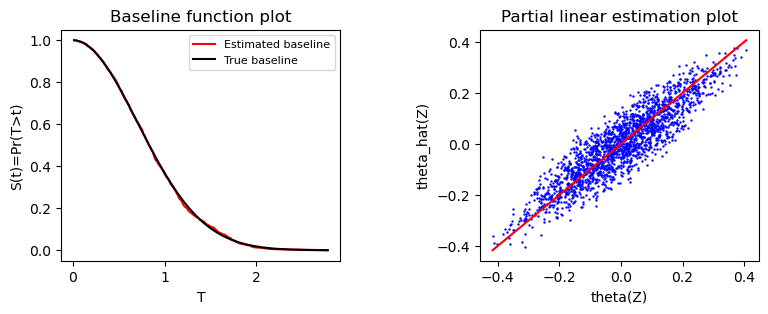

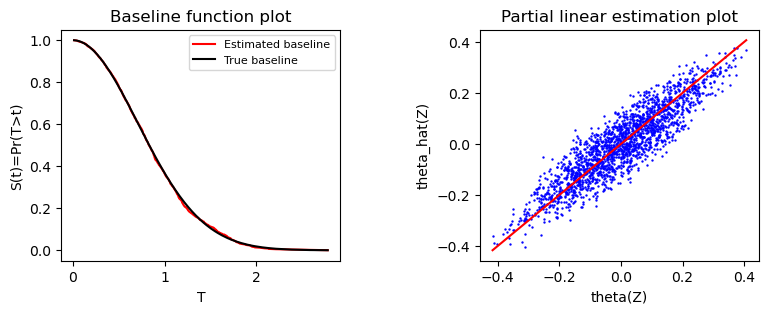

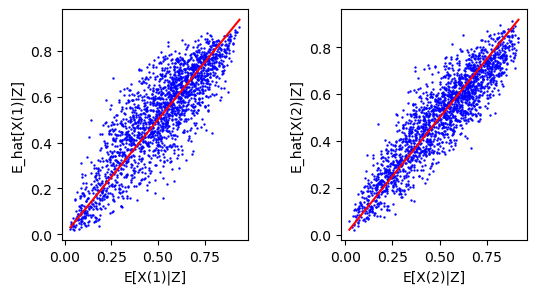

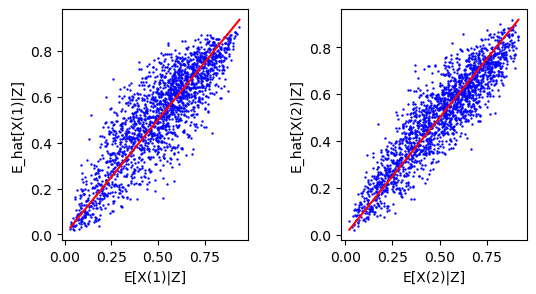

In [6]:
def Baseline_func(x): return torch.exp(-x**2)
deepSurv1.plot(theta=theta,Baseline=Baseline_func,Z_new=sim_data_test.Z)
deepSurv2.plot(theta=theta,Baseline=Baseline_func,Z_new=sim_data_test.Z)
model_XZ1.plot2(sim_data,E_XZ=E_XZ, Z_new=sim_data_test.Z)
model_XZ2.plot2(sim_data,E_XZ=E_XZ, Z_new=sim_data_test.Z)

## Testing doubly robust method for $\theta(z)=\exp\{-\sum_{j=1}^{10}z_j^2/2\}$

In [8]:
# sampling number
N=2000
# parameter part
beta = torch.tensor([-0.2,0.3])
Z_dim=10
# Non-parameter part
def theta(x):
    return torch.unsqueeze(torch.exp(-torch.norm(x,dim=1)**2/2),1)

def E_XZ(Z,X_dim):
    np.random.seed(204)
    A = torch.tensor(np.random.normal(0,1,size=( 3*Z.shape[1], X_dim))).float()
    eta = torch.cat((2*torch.sin(Z*2), 0.1*Z,torch.sin(Z*6)),1) @ A
    return torch.sigmoid(feature_normalize(eta))

def dist_Z(N,Z_dim=Z_dim,rho_Z=0.8):
    mean = torch.zeros(Z_dim)
    covariance_matrix = torch.zeros((Z_dim, Z_dim))
    
    for i in range(Z_dim):
        for j in range(Z_dim):
            covariance_matrix[i, j] = rho_Z**np.abs(i-j)
    multivariate_normal = MultivariateNormal(mean, covariance_matrix)
    Z = multivariate_normal.sample((N,))
    
    normal_dist = Normal(mean, 1)
    Z = normal_dist.cdf(Z)
    return Z

# define the neural network framework used to train theta(Z)
model_theta = nn.Sequential(
    nn.Linear(Z_dim,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,1),
)

# define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
model_XZ = nn.Sequential(
    nn.Linear(Z_dim,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,len(beta)),
    nn.Sigmoid(),
)

Epoch_XZ=261
lr_XZ=4e-3
Epoch_theta=261
lr_theta=9e-4
# lr_theta=45e-4

censor_ave=2
accuray=0.1
cut=3

### Nuisance function fitting

uncensoring sample number:  tensor(1314., device='cuda:0')
train theta:
epoch: 0 Train_loss:4.24708, epoch: 0 Test_loss:4.24163
epoch: 10 Train_loss:4.22230, epoch: 10 Test_loss:4.21235
epoch: 20 Train_loss:4.20933, epoch: 20 Test_loss:4.19515
epoch: 30 Train_loss:4.20664, epoch: 30 Test_loss:4.19146
epoch: 40 Train_loss:4.20354, epoch: 40 Test_loss:4.19226
epoch: 50 Train_loss:4.20091, epoch: 50 Test_loss:4.19217
epoch: 60 Train_loss:4.19832, epoch: 60 Test_loss:4.19114
epoch: 70 Train_loss:4.19565, epoch: 70 Test_loss:4.19089
epoch: 80 Train_loss:4.19273, epoch: 80 Test_loss:4.19089
epoch: 90 Train_loss:4.18946, epoch: 90 Test_loss:4.19076
epoch: 100 Train_loss:4.18588, epoch: 100 Test_loss:4.19095
tensor([-0.0867, -0.0115])


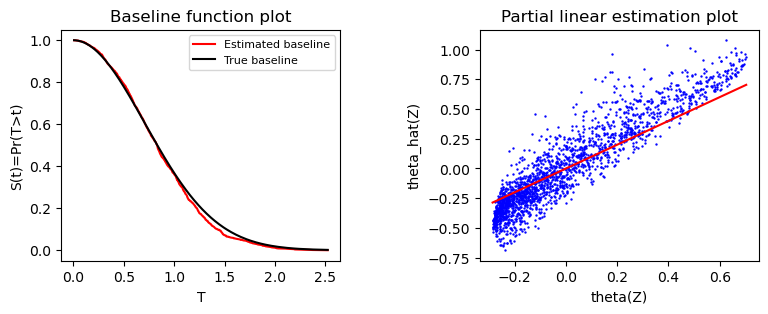

In [9]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')


# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

# T_interval = torch.quantile(sim_data.T,torch.arange(0,0.9,0.2).to(device))
# print('train E[X|Z,T>t]')
# model_XZ1 = fit_XZ_complete(sim_data,T_interval,device=device,loss_fn=nn.BCELoss(),
#                            model=model_XZ, lr=lr_XZ, Epoch=Epoch_XZ,
#                            Test_set=sim_data_test)

print('train theta:')
beta_est,theta_est = fit_CoxPH(sim_data,device=device, Early_stop= True,
                               model=model_theta, lr=lr_theta, Epoch=Epoch_theta,
                               Test_set=sim_data_test)
print(beta_est.cpu()-beta)
deepSurv = DeepSurv(sim_data,beta_est,theta_est,device)
def Baseline_func(x): return torch.exp(-x**2)
deepSurv.plot(theta=theta,Baseline=Baseline_func, Z_new = sim_data_test.Z)

uncensoring sample number:  tensor(1359., device='cuda:0')
train E[X|Z,T>t]
epoch: 0 Train_loss:3.47814, epoch: 0 Test_loss:3.40719
epoch: 10 Train_loss:3.17876, epoch: 10 Test_loss:3.08690
epoch: 20 Train_loss:3.09842, epoch: 20 Test_loss:3.03412
epoch: 30 Train_loss:3.07168, epoch: 30 Test_loss:3.03606
epoch: 40 Train_loss:3.04281, epoch: 40 Test_loss:3.02709
epoch: 50 Train_loss:3.00859, epoch: 50 Test_loss:3.02808


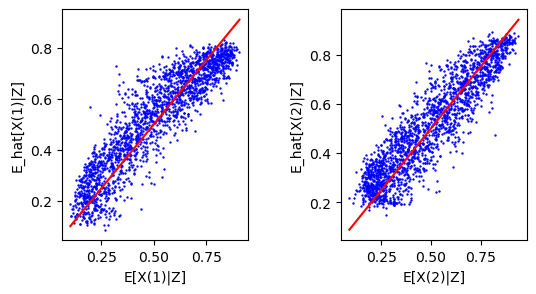

In [10]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')


# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

T_interval = torch.quantile(sim_data.T,torch.arange(0,0.9,0.2).to(device))
print('train E[X|Z,T>t]')
model_XZ1 = fit_XZ_complete(sim_data,T_interval,device=device,loss_fn=nn.BCELoss(),
                           model=model_XZ, lr=lr_XZ, Epoch=Epoch_XZ,
                           Test_set=sim_data_test)
model_XZ1.plot2(sim_data,E_XZ=E_XZ, Z_new = sim_data_test.Z)

### Doubly robust fitting

In [7]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')

# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

# train the double robust model
(beta_DB, var_est_DB, 
 beta_est1, deepSurv1,  model_XZ1, 
 beta_est2, deepSurv2, model_XZ2) = DML_CoxPH(sim_data, device=device,accuracy=0.2, Early_stop=True,
                                              Test_set= sim_data_test,loss_XZ=nn.BCELoss(),
                                              model_XZ=model_XZ, model_theta=model_theta,
                                              Epoch_XZ=Epoch_XZ, Epoch_theta=Epoch_theta,
                                              lr_XZ=lr_XZ, lr_theta=lr_theta,
                                              print_state=True)


net = CustomNet(h_dims=[1, 50,50,50, len(beta)], g_dims=[Z_dim,50,50,50, len(beta)])
var_est_naive = fit_variance(sim_data, net, device=device, lr=8e-3,print_state=True)

# calculate the direct parameter estimator without using double robust techniques
beta_naive=(beta_est1+beta_est2)/2
# calculate the p_value
beta=beta.to(device)

未删失样本数： tensor(1338., device='cuda:4')
train theta(Z)
epoch: 0 Train_loss:4.29881, epoch: 0 Test_loss:4.25196
epoch: 10 Train_loss:4.28166, epoch: 10 Test_loss:4.23398
epoch: 20 Train_loss:4.27962, epoch: 20 Test_loss:4.23258
epoch: 30 Train_loss:4.27718, epoch: 30 Test_loss:4.23237
epoch: 40 Train_loss:4.27513, epoch: 40 Test_loss:4.23203
epoch: 50 Train_loss:4.27295, epoch: 50 Test_loss:4.23224
train E[X|Z,T>t]
epoch: 0 Train_loss:3.49303, epoch: 0 Test_loss:3.42898
epoch: 10 Train_loss:3.18652, epoch: 10 Test_loss:3.19896
epoch: 20 Train_loss:3.07441, epoch: 20 Test_loss:3.11370
epoch: 30 Train_loss:3.03418, epoch: 30 Test_loss:3.09522
epoch: 40 Train_loss:3.00435, epoch: 40 Test_loss:3.09055
epoch: 50 Train_loss:2.97308, epoch: 50 Test_loss:3.09325
train theta(Z)
epoch: 0 Train_loss:4.32953, epoch: 0 Test_loss:4.28461
epoch: 10 Train_loss:4.30196, epoch: 10 Test_loss:4.25492
epoch: 20 Train_loss:4.29633, epoch: 20 Test_loss:4.24908
epoch: 30 Train_loss:4.29221, epoch: 30 Test_loss:

In [ ]:
print()
chi_value = torch.squeeze((beta_naive-beta) @ torch.inverse(var_est_naive) @ torch.unsqueeze(beta_naive-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_naive))
p_value_single = 1 - chi2.cdf(((beta_naive-beta)**2/torch.diag(var_est_naive)).cpu(),1)
print('PL Cox bias：',beta_naive-beta,'bias norm:',torch.norm(beta_naive-beta))
print('PL Cox standard error：',torch.sqrt(torch.diag(var_est_naive)))
print('PL Cox test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_naive)):
    print('PL Cox test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))


print()
chi_value = torch.squeeze((beta_DB-beta) @ torch.inverse(var_est_DB) @ torch.unsqueeze(beta_DB-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_DB))
p_value_single = 1 - chi2.cdf(((beta_DB-beta)**2/torch.diag(var_est_DB)).cpu(),1)
print('DBPL bias：',beta_DB-beta,'DBPL bias：',torch.norm(beta_DB-beta))
print('DBPL standard error：',torch.sqrt(torch.diag(var_est_DB)))
print('DBPL test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_DB)):
    print('DBPL test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))

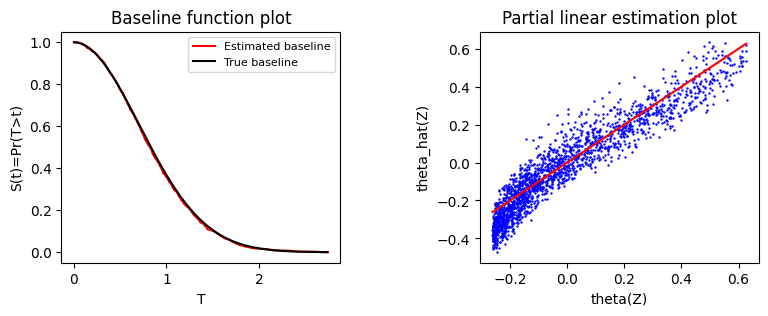

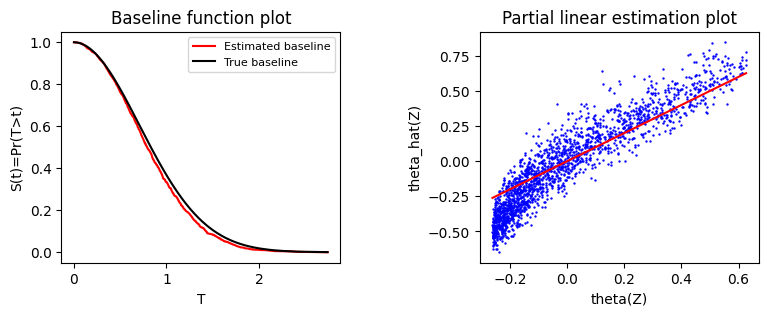

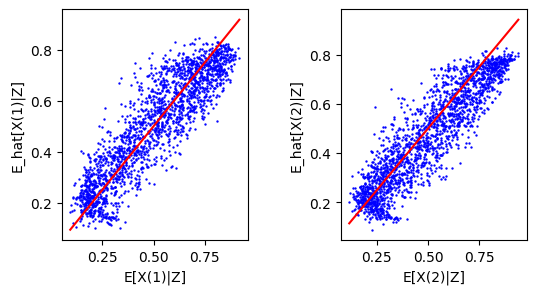

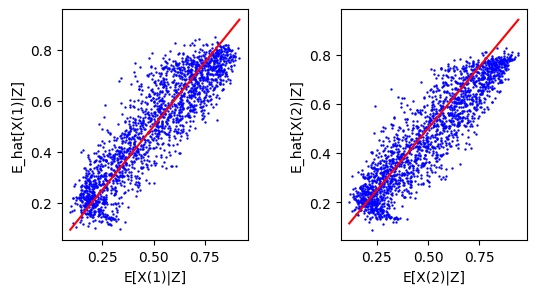

In [8]:
Baseline_func = lambda x: torch.exp(-x**2)
deepSurv1.plot(theta=theta,Baseline=Baseline_func, Z_new = sim_data_test.Z)
deepSurv2.plot(theta=theta,Baseline=Baseline_func, Z_new = sim_data_test.Z)
model_XZ1.plot2(sim_data,E_XZ=E_XZ, Z_new = sim_data_test.Z)
model_XZ2.plot2(sim_data,E_XZ=E_XZ, Z_new = sim_data_test.Z)

In [19]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')
net = CustomNet(h_dims=[1, 50,100,100, len(beta)], g_dims=[Z_dim,50,100,100, len(beta)])
var_est_naive = fit_variance(sim_data, net, device=device, lr=6e-3,print_state=True)
print(torch.sqrt(torch.diag(var_est_naive)))

Epoch 10, Train Loss: 0.604704, Val Loss: 0.606633
Epoch 20, Train Loss: 0.486627, Val Loss: 0.489347
Epoch 30, Train Loss: 0.410458, Val Loss: 0.413872
Epoch 40, Train Loss: 0.368288, Val Loss: 0.371896
Epoch 50, Train Loss: 0.348817, Val Loss: 0.352064
Epoch 60, Train Loss: 0.341542, Val Loss: 0.344131
Epoch 70, Train Loss: 0.339414, Val Loss: 0.341364
Epoch 80, Train Loss: 0.338944, Val Loss: 0.340452
Epoch 90, Train Loss: 0.338864, Val Loss: 0.340150
Epoch 100, Train Loss: 0.338846, Val Loss: 0.340068
Epoch 110, Train Loss: 0.338836, Val Loss: 0.340074
直接估计标准差： tensor([0.0547, 0.0547], device='cuda:4')


## Testing doubly robust method for $\theta(z)=\sin\{-\sum_{j=1}^{10}z_j^2/4\}$

In [7]:
# sampling number
N=2000
# parameter part
beta = torch.tensor([-0.2,0.1])
Z_dim=10
# Non-parameter part
def theta(x):
    return torch.unsqueeze(torch.sin(-torch.norm(x,dim=1)**2/4),1)

def E_XZ(Z,X_dim):
    np.random.seed(204)
    A = torch.tensor(np.random.normal(0,1,size=( 3*Z.shape[1], X_dim))).float()
    eta = torch.cat((2*torch.sin(2*Z), 0.1*Z,torch.sin(6*Z)),1) @ A
    return torch.sigmoid(feature_normalize(eta))

def dist_Z(N,Z_dim=Z_dim,rho_Z=0):
    mean = torch.zeros(Z_dim)
    covariance_matrix = torch.zeros((Z_dim, Z_dim))
    
    for i in range(Z_dim):
        for j in range(Z_dim):
            covariance_matrix[i, j] = rho_Z**np.abs(i-j)
    multivariate_normal = MultivariateNormal(mean, covariance_matrix)
    Z = multivariate_normal.sample((N,))
    
    normal_dist = Normal(mean, 1)
    Z = normal_dist.cdf(Z)
    return Z

# define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
model_XZ = nn.Sequential(
    nn.Linear(Z_dim,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,len(beta)),
    nn.Sigmoid(),
)

# define the neural network framework used to train theta(Z)
model_theta = nn.Sequential(
    nn.Linear(Z_dim,25),
    nn.ReLU(),
    nn.Linear(25,25),
    nn.ReLU(),
    nn.Linear(25,1),
)


Epoch_XZ=1101
lr_XZ=15e-4
Epoch_theta=2201
lr_theta=25e-4

censor_ave=2
accuray=0.1
cut=3

### Nuisance function fitting

未删失样本数： tensor(1195., device='cuda:4')
train E[X|Z,T>t]
epoch: 0 Train_loss:3.45285, epoch: 0 Test_loss:3.43474
epoch: 10 Train_loss:3.29690, epoch: 10 Test_loss:3.31313
epoch: 20 Train_loss:3.15578, epoch: 20 Test_loss:3.26163
epoch: 30 Train_loss:3.10851, epoch: 30 Test_loss:3.27182
epoch: 40 Train_loss:3.06893, epoch: 40 Test_loss:3.25597
epoch: 50 Train_loss:3.02413, epoch: 50 Test_loss:3.26891


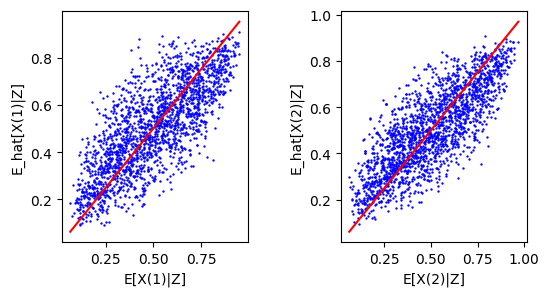

In [45]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')
# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

T_interval = torch.quantile(sim_data.T,torch.arange(0,0.9,0.2).to(device))
print('train E[X|Z,T>t]')
model_XZ1 = fit_XZ_complete(sim_data,T_interval,device=device,loss_fn=nn.BCELoss(),
                           model=model_XZ, lr=lr_XZ, Epoch=Epoch_XZ,
                           Test_set=sim_data_test)

model_XZ1.plot2(sim_data,E_XZ=E_XZ, Z_new = sim_data_test.Z)

train theta:
epoch: 0 Train_loss:4.11391, epoch: 0 Test_loss:4.00892
epoch: 10 Train_loss:4.07408, epoch: 10 Test_loss:3.97000
epoch: 20 Train_loss:4.02059, epoch: 20 Test_loss:3.91423
epoch: 30 Train_loss:3.94075, epoch: 30 Test_loss:3.83177
epoch: 40 Train_loss:3.84164, epoch: 40 Test_loss:3.73192
epoch: 50 Train_loss:3.75729, epoch: 50 Test_loss:3.65039
epoch: 60 Train_loss:3.72036, epoch: 60 Test_loss:3.61633
epoch: 70 Train_loss:3.70636, epoch: 70 Test_loss:3.60426
epoch: 80 Train_loss:3.69440, epoch: 80 Test_loss:3.59698
epoch: 90 Train_loss:3.68487, epoch: 90 Test_loss:3.59138
epoch: 100 Train_loss:3.67631, epoch: 100 Test_loss:3.58845
epoch: 110 Train_loss:3.66820, epoch: 110 Test_loss:3.58679
epoch: 120 Train_loss:3.66017, epoch: 120 Test_loss:3.58573
epoch: 130 Train_loss:3.65206, epoch: 130 Test_loss:3.58535
epoch: 140 Train_loss:3.64432, epoch: 140 Test_loss:3.58551
tensor([-0.0152, -0.1252])


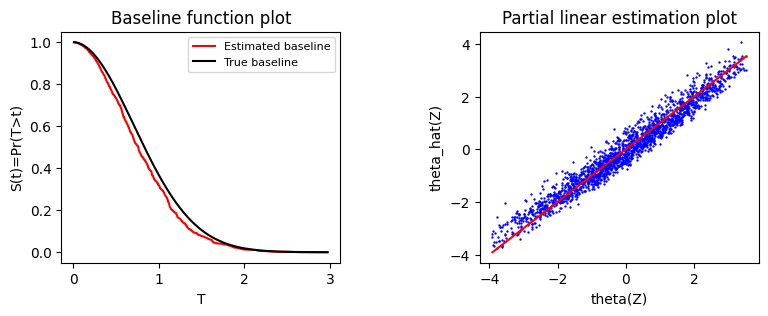

In [44]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')

print('train theta:')
beta_est,theta_est = fit_CoxPH(sim_data,device=device, Early_stop= True,
                               model=model_theta, lr=lr_theta, Epoch=Epoch_theta,
                               Test_set=sim_data_test)
print(beta_est.cpu()-beta.cpu())
deepSurv = DeepSurv(sim_data,beta_est,theta_est,device)
def Baseline_func(x): return torch.exp(-x**2)
deepSurv.plot(theta=theta,Baseline=Baseline_func, Z_new = sim_data_test.Z)

### Doubly robust fitting

In [11]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')

# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

# train the double robust model
(beta_DB, var_est_DB, 
 beta_est1, deepSurv1,  model_XZ1, 
 beta_est2, deepSurv2, model_XZ2) = DML_CoxPH(sim_data, device=device,accuracy=0.2, Early_stop=True,
                                              Test_set= sim_data_test,loss_XZ=nn.BCELoss(),
                                              model_XZ=model_XZ, model_theta=model_theta,
                                              Epoch_XZ=Epoch_XZ, Epoch_theta=Epoch_theta,
                                              lr_XZ=lr_XZ, lr_theta=lr_theta,
                                              print_state=True)

net = CustomNet(h_dims=[1, 50,50,50, len(beta)], g_dims=[Z_dim,50,50,50, len(beta)])
var_est_naive = fit_variance(sim_data, net, device=device, lr=6e-3,print_state=True)

# calculate the direct parameter estimator without using double robust techniques
beta_naive=(beta_est1+beta_est2)/2
# calculate the p_value
beta=beta.to(device)

uncensoring sample number:  tensor(1328., device='cuda:0')
train theta(Z)
epoch: 0 Train_loss:4.25438, epoch: 0 Test_loss:4.33339
epoch: 10 Train_loss:4.24359, epoch: 10 Test_loss:4.32219
epoch: 20 Train_loss:4.24113, epoch: 20 Test_loss:4.31908
epoch: 30 Train_loss:4.23854, epoch: 30 Test_loss:4.31787
epoch: 40 Train_loss:4.23604, epoch: 40 Test_loss:4.31709
epoch: 50 Train_loss:4.23332, epoch: 50 Test_loss:4.31696
epoch: 60 Train_loss:4.23035, epoch: 60 Test_loss:4.31774
train E[X|Z,T>t]
epoch: 0 Train_loss:3.47627, epoch: 0 Test_loss:3.42160
epoch: 10 Train_loss:3.19879, epoch: 10 Test_loss:3.09412
epoch: 20 Train_loss:3.11012, epoch: 20 Test_loss:2.99546
epoch: 30 Train_loss:3.07665, epoch: 30 Test_loss:3.00682
epoch: 40 Train_loss:3.04492, epoch: 40 Test_loss:2.99681
epoch: 50 Train_loss:3.01219, epoch: 50 Test_loss:2.99434
epoch: 60 Train_loss:2.97653, epoch: 60 Test_loss:2.99871
train theta(Z)
epoch: 0 Train_loss:4.26159, epoch: 0 Test_loss:4.34852
epoch: 10 Train_loss:4.24579, 

In [15]:
print()
chi_value = torch.squeeze((beta_naive-beta) @ torch.inverse(var_est_naive) @ torch.unsqueeze(beta_naive-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_naive))
p_value_single = 1 - chi2.cdf(((beta_naive-beta)**2/torch.diag(var_est_naive)).cpu(),1)
print('PL Cox bias：',beta_naive-beta,'bias norm:',torch.norm(beta_naive-beta))
print('PL Cox standard error：',torch.sqrt(torch.diag(var_est_naive)))
print('PL Cox test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_naive)):
    print('PL Cox test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))


print()
chi_value = torch.squeeze((beta_DB-beta) @ torch.inverse(var_est_DB) @ torch.unsqueeze(beta_DB-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_DB))
p_value_single = 1 - chi2.cdf(((beta_DB-beta)**2/torch.diag(var_est_DB)).cpu(),1)
print('DBPL bias：',beta_DB-beta,'DBPL bias：',torch.norm(beta_DB-beta))
print('DBPL standard error：',torch.sqrt(torch.diag(var_est_DB)))
print('DBPL test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_DB)):
    print('DBPL test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))


PL Cox bias： tensor([-0.0749, -0.0160], device='cuda:0') bias norm: tensor(0.0766, device='cuda:0')
PL Cox standard error： tensor([0.0604, 0.0625], device='cuda:0')
PL Cox test H_0: β=β_0, p value：0.44936
PL Cox test H_0: β[0]=β_0[0], p value：0.21509
PL Cox test H_0: β[1]=β_0[1], p value：0.79758

DBPL bias： tensor([-0.0597, -0.0344], device='cuda:0') DBPL bias： tensor(0.0689, device='cuda:0')
DBPL standard error： tensor([0.0596, 0.0601], device='cuda:0')
DBPL test H_0: β=β_0, p value：0.53029
DBPL test H_0: β[0]=β_0[0], p value：0.31639
DBPL test H_0: β[1]=β_0[1], p value：0.56672


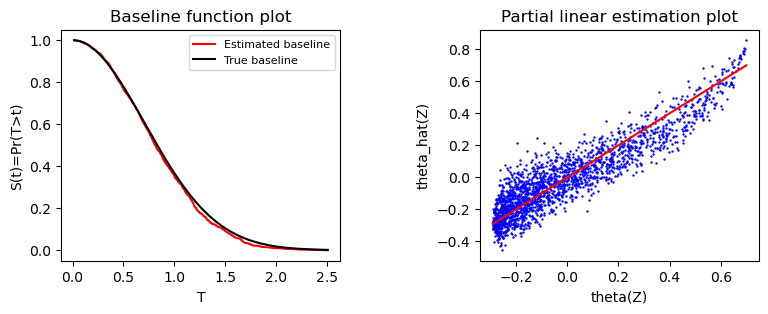

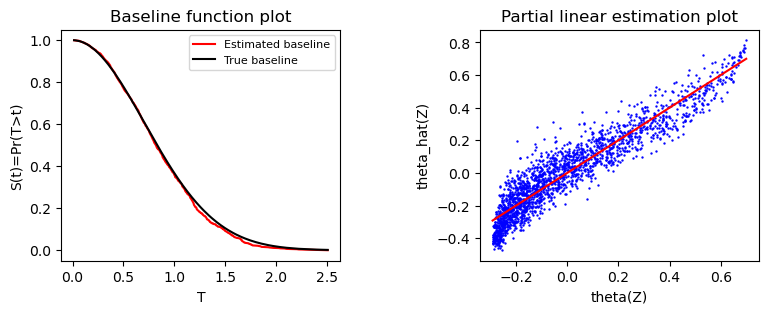

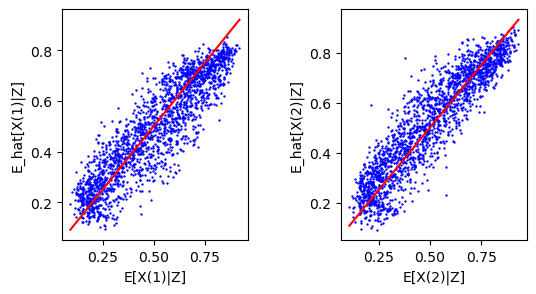

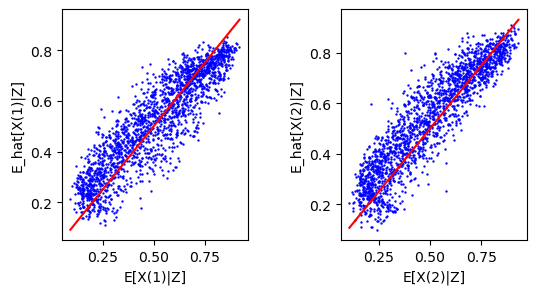

In [14]:
Baseline_func = lambda x: torch.exp(-x**2)
deepSurv1.plot(theta=theta,Baseline=Baseline_func, Z_new = sim_data_test.Z)
deepSurv2.plot(theta=theta,Baseline=Baseline_func, Z_new = sim_data_test.Z)
model_XZ1.plot2(sim_data,E_XZ=E_XZ, Z_new = sim_data_test.Z)
model_XZ2.plot2(sim_data,E_XZ=E_XZ, Z_new = sim_data_test.Z)

## Testing doubly robust method for $\theta(z)=z_1^2 + 2z_2^2+ z_3^3+\sqrt{z_4+1}+\log(z_5+1)-8.6$

In [7]:
# sampling number
N=2000
# parameter part
beta = torch.tensor([-0.2,0.1])
Z_dim=5
# Non-parameter part
def theta(x):
    return torch.unsqueeze(x[:,0]**2 + 2*x[:,1]**2 + x[:,2]**3 + torch.sqrt(x[:,3]+1)+torch.log(x[:,4]+1)-8.6,1)
    # return torch.unsqueeze(torch.sqrt(x[:,3]+1)+x[:,4]/5,1)
    #return torch.unsqueeze(torch.mean(x,1),1)

def E_XZ(Z,X_dim):
    np.random.seed(204)
    A = torch.tensor(np.random.normal(0,1,size=( 3*Z.shape[1], X_dim))).float()
    eta = torch.cat((2*torch.sin(2*Z), 0.1*Z,torch.sin(6*Z)),1) @ A
    return torch.sigmoid(feature_normalize(eta))

def dist_Z(N,Z_dim=Z_dim,rho_Z=0):
    mean = torch.zeros(Z_dim)
    covariance_matrix = torch.zeros((Z_dim, Z_dim))
    
    for i in range(Z_dim):
        for j in range(Z_dim):
            covariance_matrix[i, j] = rho_Z**np.abs(i-j)
    multivariate_normal = MultivariateNormal(mean, covariance_matrix)
    Z = multivariate_normal.sample((N,))
    
    normal_dist = Normal(mean, 1)
    Z = normal_dist.cdf(Z)
    return Z


# define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
model_XZ = nn.Sequential(
    nn.Linear(Z_dim,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,len(beta)),
    nn.Sigmoid(),
)

# define the neural network framework used to train theta(Z)
model_theta = nn.Sequential(
    nn.Linear(Z_dim,25),
    nn.ReLU(),
    nn.Linear(25,25),
    nn.ReLU(),
    nn.Linear(25,1),
)


Epoch_XZ=1101
lr_XZ=30e-4
Epoch_theta=2201
lr_theta=120e-4

censor_ave=2
accuray=0.1
cut=3

### Nuisance function fitting

In [3]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')


# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

T_interval = torch.quantile(sim_data.T,torch.arange(0,0.9,0.2).to(device))
print('train E[X|Z,T>t]')
model_XZ1 = fit_XZ_complete(sim_data,T_interval,device=device,loss_fn=nn.BCELoss(),
                           model=model_XZ, lr=lr_XZ, Epoch=Epoch_XZ,
                           Test_set=sim_data_test)

print('train theta:')
beta_est,theta_est = fit_CoxPH(sim_data,device=device,
                               model=model_theta, lr=lr_theta, Epoch=Epoch_theta,
                               Test_set=sim_data_test)
print(beta_est.cpu()-beta)

未删失样本数： tensor(883., device='cuda:4')
train E[X|Z,T>t]
epoch: 0 Train_loss:3.47053, epoch: 0 Test_loss:3.43756
epoch: 10 Train_loss:3.13010, epoch: 10 Test_loss:3.11786
epoch: 20 Train_loss:3.07711, epoch: 20 Test_loss:3.11622
epoch: 30 Train_loss:3.03736, epoch: 30 Test_loss:3.08554
epoch: 40 Train_loss:2.98424, epoch: 40 Test_loss:3.06618
epoch: 50 Train_loss:2.93119, epoch: 50 Test_loss:3.05115
epoch: 60 Train_loss:2.89251, epoch: 60 Test_loss:3.05888
train theta:
epoch: 0 Train_loss:2.85066, epoch: 0 Test_loss:2.83516
epoch: 10 Train_loss:2.71884, epoch: 10 Test_loss:2.70778
epoch: 20 Train_loss:2.69083, epoch: 20 Test_loss:2.68591
epoch: 30 Train_loss:2.68117, epoch: 30 Test_loss:2.68157
epoch: 40 Train_loss:2.67655, epoch: 40 Test_loss:2.67430
epoch: 50 Train_loss:2.67346, epoch: 50 Test_loss:2.67468
tensor([0.0140, 0.0171])


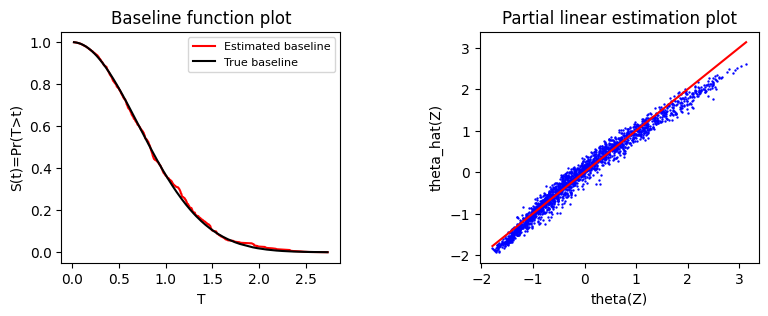

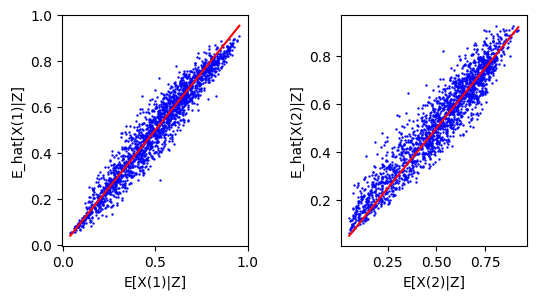

In [4]:
def Baseline_func(x): return torch.exp(-x**2)
deepSurv = DeepSurv(sim_data,beta_est,theta_est,device)
deepSurv.plot(theta=theta,Baseline=Baseline_func,Z_new=sim_data_test.Z)
model_XZ1.plot2(sim_data,E_XZ=E_XZ,Z_new=sim_data_test.Z)

### Doubly robust fitting

In [8]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')


# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

# train the double robust model
(beta_DB, var_est_DB, 
 beta_est1, deepSurv1,  model_XZ1, 
 beta_est2, deepSurv2, model_XZ2) = DML_CoxPH(sim_data, device=device,accuracy=0.2, Early_stop=True,
                                              Test_set= sim_data_test,loss_XZ=nn.BCELoss(),
                                              model_XZ=model_XZ, model_theta=model_theta,
                                              Epoch_XZ=Epoch_XZ, Epoch_theta=Epoch_theta,
                                              lr_XZ=lr_XZ, lr_theta=lr_theta,
                                              print_state=True)

net = CustomNet(h_dims=[1, 50,100,100, len(beta)], g_dims=[Z_dim,50,100,100, len(beta)])
var_est_naive = fit_variance(sim_data, net, device=device, lr=5e-3,print_state=True)

# calculate the direct parameter estimator without using double robust techniques
beta_naive=(beta_est1+beta_est2)/2
# calculate the p_value
beta=beta.to(device)

未删失样本数： tensor(1304., device='cuda:4')
train theta(Z)
epoch: 0 Train_loss:4.22386, epoch: 0 Test_loss:4.09072
epoch: 10 Train_loss:4.12351, epoch: 10 Test_loss:3.97522
epoch: 20 Train_loss:4.08663, epoch: 20 Test_loss:3.94939
epoch: 30 Train_loss:4.07931, epoch: 30 Test_loss:3.94947
epoch: 40 Train_loss:4.07528, epoch: 40 Test_loss:3.95165
epoch: 50 Train_loss:4.07013, epoch: 50 Test_loss:3.94878
epoch: 60 Train_loss:4.06467, epoch: 60 Test_loss:3.95027
train E[X|Z,T>t]
epoch: 0 Train_loss:3.48805, epoch: 0 Test_loss:3.43849
epoch: 10 Train_loss:3.22005, epoch: 10 Test_loss:3.22215
epoch: 20 Train_loss:3.10796, epoch: 20 Test_loss:3.17706
epoch: 30 Train_loss:3.07866, epoch: 30 Test_loss:3.16896
epoch: 40 Train_loss:3.05895, epoch: 40 Test_loss:3.14499
epoch: 50 Train_loss:3.04007, epoch: 50 Test_loss:3.15136
train theta(Z)
epoch: 0 Train_loss:4.24628, epoch: 0 Test_loss:4.09565
epoch: 10 Train_loss:4.14242, epoch: 10 Test_loss:3.99055
epoch: 20 Train_loss:4.10495, epoch: 20 Test_loss:

In [ ]:
print()
chi_value = torch.squeeze((beta_naive-beta) @ torch.inverse(var_est_naive) @ torch.unsqueeze(beta_naive-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_naive))
p_value_single = 1 - chi2.cdf(((beta_naive-beta)**2/torch.diag(var_est_naive)).cpu(),1)
print('PL Cox bias：',beta_naive-beta,'bias norm:',torch.norm(beta_naive-beta))
print('PL Cox standard error：',torch.sqrt(torch.diag(var_est_naive)))
print('PL Cox test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_naive)):
    print('PL Cox test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))


print()
chi_value = torch.squeeze((beta_DB-beta) @ torch.inverse(var_est_DB) @ torch.unsqueeze(beta_DB-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_DB))
p_value_single = 1 - chi2.cdf(((beta_DB-beta)**2/torch.diag(var_est_DB)).cpu(),1)
print('DBPL bias：',beta_DB-beta,'DBPL bias：',torch.norm(beta_DB-beta))
print('DBPL standard error：',torch.sqrt(torch.diag(var_est_DB)))
print('DBPL test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_DB)):
    print('DBPL test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))

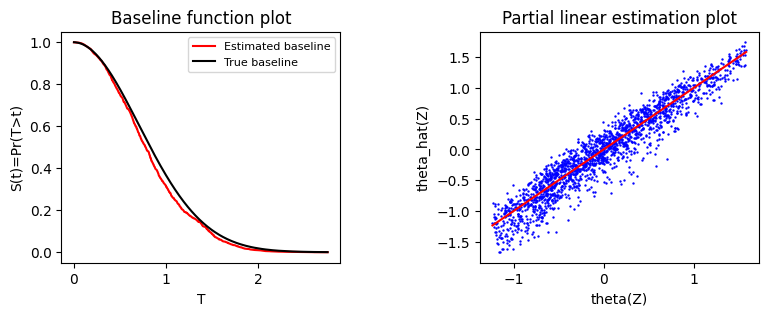

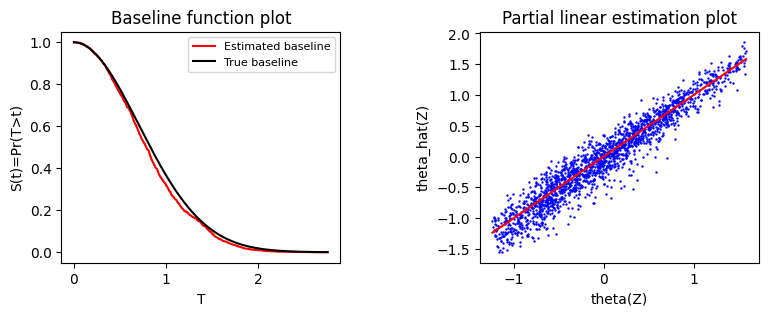

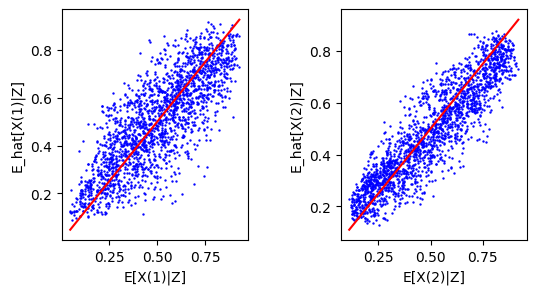

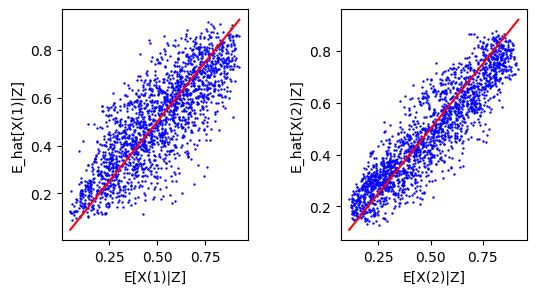

In [9]:
def Baseline_func(x): return torch.exp(-x**2)
deepSurv1.plot(theta=theta,Baseline=Baseline_func,Z_new=sim_data_test.Z)
deepSurv2.plot(theta=theta,Baseline=Baseline_func,Z_new=sim_data_test.Z)
model_XZ1.plot2(sim_data,E_XZ=E_XZ,Z_new=sim_data_test.Z)
model_XZ2.plot2(sim_data,E_XZ=E_XZ,Z_new=sim_data_test.Z)

## Testing doubly robust method for $\theta(x)=x_1^2x_2^2+\log(x_3+1)+\sqrt{x_4x_5+1}+e^{x_5/2}-8.2$

In [34]:
# sampling number
N=2000
# parameter part
beta = torch.tensor([-0.2,0.1])
Z_dim=5
# Non-parameter part
def theta(x):
    return torch.unsqueeze(x[:,0]**2 * x[:,1]**2 + torch.log((x[:,2]+1)**2)/2 + torch.sqrt(x[:,3]*x[:,4]+1)+torch.exp(x[:,4]/2)-8.2,1)
    # return torch.unsqueeze(torch.sqrt(x[:,3]+1)+x[:,4]/5,1)
    #return torch.unsqueeze(torch.mean(x,1),1)

def E_XZ(Z,X_dim):
    np.random.seed(204)
    A = torch.tensor(np.random.normal(0,1,size=( 3*Z.shape[1], X_dim))).float()
    eta = torch.cat((2*torch.sin(Z*2), 0.1*Z,torch.sin(Z*6)),1) @ A
    return torch.sigmoid(feature_normalize(eta))


def dist_Z(N,Z_dim=Z_dim,rho_Z=0):
    mean = torch.zeros(Z_dim)
    covariance_matrix = torch.zeros((Z_dim, Z_dim))
    
    for i in range(Z_dim):
        for j in range(Z_dim):
            covariance_matrix[i, j] = rho_Z**np.abs(i-j)
    multivariate_normal = MultivariateNormal(mean, covariance_matrix)
    Z = multivariate_normal.sample((N,))
    
    normal_dist = Normal(mean, 1)
    Z = normal_dist.cdf(Z)
    return Z


# define the neural network framework used to train theta(Z)
model_XZ = nn.Sequential(
    nn.Linear(Z_dim,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,len(beta)),
    nn.Sigmoid(),
)

# define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
model_theta = nn.Sequential(
    nn.Linear(Z_dim,50),
    nn.ReLU(),
    nn.Linear(50,50),
    nn.ReLU(),
    nn.Linear(50,1),
)




Epoch_XZ=1101
lr_XZ=20e-4
Epoch_theta=2201
lr_theta=80e-4

censor_ave=2
accuray=0.1
cut=3

### Nuisance function fitting

In [20]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')



# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

T_interval = torch.quantile(sim_data.T,torch.arange(0,0.9,0.2).to(device))
print('train E[X|Z,T>t]')
model_XZ1 = fit_XZ_complete(sim_data,T_interval,device=device,loss_fn=nn.BCELoss(),
                           model=model_XZ, lr=lr_XZ, Epoch=Epoch_XZ,
                           Test_set=sim_data_test)

print('train theta:')
beta_est,theta_est = fit_CoxPH(sim_data,device=device,
                               model=model_theta, lr=lr_theta, Epoch=Epoch_theta,
                               Test_set=sim_data_test)
print(beta_est.cpu()-beta)

未删失样本数： tensor(1312., device='cuda:4')
train E[X|Z,T>t]
epoch: 0 Train_loss:3.46870, epoch: 0 Test_loss:3.43876
epoch: 10 Train_loss:3.21541, epoch: 10 Test_loss:3.21759
epoch: 20 Train_loss:3.10540, epoch: 20 Test_loss:3.17690
epoch: 30 Train_loss:3.06925, epoch: 30 Test_loss:3.14943
epoch: 40 Train_loss:3.03512, epoch: 40 Test_loss:3.15014
epoch: 50 Train_loss:2.99906, epoch: 50 Test_loss:3.15247
train theta:
epoch: 0 Train_loss:4.26842, epoch: 0 Test_loss:4.15120
epoch: 10 Train_loss:4.23185, epoch: 10 Test_loss:4.11732
epoch: 20 Train_loss:4.22178, epoch: 20 Test_loss:4.10839
epoch: 30 Train_loss:4.21303, epoch: 30 Test_loss:4.10320
epoch: 40 Train_loss:4.20567, epoch: 40 Test_loss:4.10021
epoch: 50 Train_loss:4.19832, epoch: 50 Test_loss:4.09571
epoch: 60 Train_loss:4.19160, epoch: 60 Test_loss:4.09327
epoch: 70 Train_loss:4.18561, epoch: 70 Test_loss:4.09124
epoch: 80 Train_loss:4.18034, epoch: 80 Test_loss:4.08967
epoch: 90 Train_loss:4.17588, epoch: 90 Test_loss:4.08888
epoch: 

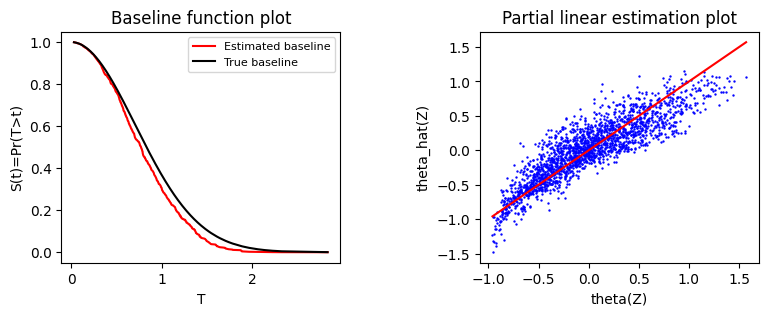

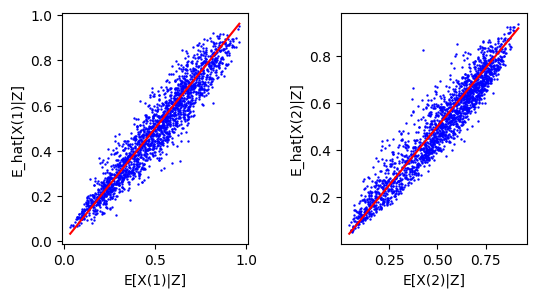

In [52]:
def Baseline_func(x): return torch.exp(-x**2)
deepSurv = DeepSurv(sim_data,beta_est,theta_est,device)
deepSurv.plot(theta=theta,Baseline=Baseline_func,Z_new=sim_data_test.Z)
model_XZ1.plot2(sim_data,E_XZ=E_XZ,Z_new=sim_data_test.Z)

### Doubly robust fitting

In [31]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')


# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

# train the double robust model
(beta_DB, var_est_DB, 
 beta_est1, deepSurv1,  model_XZ1, 
 beta_est2, deepSurv2, model_XZ2) = DML_CoxPH(sim_data, device=device,accuracy=0.2, Early_stop=True,
                                              Test_set= sim_data_test,loss_XZ=nn.BCELoss(),
                                              model_XZ=model_XZ, model_theta=model_theta,
                                              Epoch_XZ=Epoch_XZ, Epoch_theta=Epoch_theta,
                                              lr_XZ=lr_XZ, lr_theta=lr_theta,
                                              print_state=True)

net = CustomNet(h_dims=[1, 50,100,100, len(beta)], g_dims=[Z_dim,50,100,100, len(beta)])
var_est_naive = fit_variance(sim_data, net, device=device, lr=5e-3,print_state=True)

# calculate the direct parameter estimator without using double robust techniques
beta_naive=(beta_est1+beta_est2)/2
# calculate the p_value
beta=beta.to(device)

未删失样本数： tensor(1291., device='cuda:4')
train theta(Z)
epoch: 0 Train_loss:4.17259, epoch: 0 Test_loss:4.15983
epoch: 10 Train_loss:4.12732, epoch: 10 Test_loss:4.13511
epoch: 20 Train_loss:4.11583, epoch: 20 Test_loss:4.12393
epoch: 30 Train_loss:4.10780, epoch: 30 Test_loss:4.12624
epoch: 40 Train_loss:4.10386, epoch: 40 Test_loss:4.12795
epoch: 50 Train_loss:4.10085, epoch: 50 Test_loss:4.12588
epoch: 60 Train_loss:4.09808, epoch: 60 Test_loss:4.12736
train E[X|Z,T>t]
epoch: 0 Train_loss:3.47251, epoch: 0 Test_loss:3.45173
epoch: 10 Train_loss:3.27765, epoch: 10 Test_loss:3.27993
epoch: 20 Train_loss:3.11544, epoch: 20 Test_loss:3.18489
epoch: 30 Train_loss:3.09536, epoch: 30 Test_loss:3.20866
epoch: 40 Train_loss:3.07409, epoch: 40 Test_loss:3.19086
epoch: 50 Train_loss:3.05293, epoch: 50 Test_loss:3.19845
train theta(Z)
epoch: 0 Train_loss:4.15791, epoch: 0 Test_loss:4.15789
epoch: 10 Train_loss:4.11746, epoch: 10 Test_loss:4.13929
epoch: 20 Train_loss:4.10892, epoch: 20 Test_loss:

In [ ]:
print()
chi_value = torch.squeeze((beta_naive-beta) @ torch.inverse(var_est_naive) @ torch.unsqueeze(beta_naive-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_naive))
p_value_single = 1 - chi2.cdf(((beta_naive-beta)**2/torch.diag(var_est_naive)).cpu(),1)
print('PL Cox bias：',beta_naive-beta,'bias norm:',torch.norm(beta_naive-beta))
print('PL Cox standard error：',torch.sqrt(torch.diag(var_est_naive)))
print('PL Cox test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_naive)):
    print('PL Cox test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))


print()
chi_value = torch.squeeze((beta_DB-beta) @ torch.inverse(var_est_DB) @ torch.unsqueeze(beta_DB-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_DB))
p_value_single = 1 - chi2.cdf(((beta_DB-beta)**2/torch.diag(var_est_DB)).cpu(),1)
print('DBPL bias：',beta_DB-beta,'DBPL bias：',torch.norm(beta_DB-beta))
print('DBPL standard error：',torch.sqrt(torch.diag(var_est_DB)))
print('DBPL test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_DB)):
    print('DBPL test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))

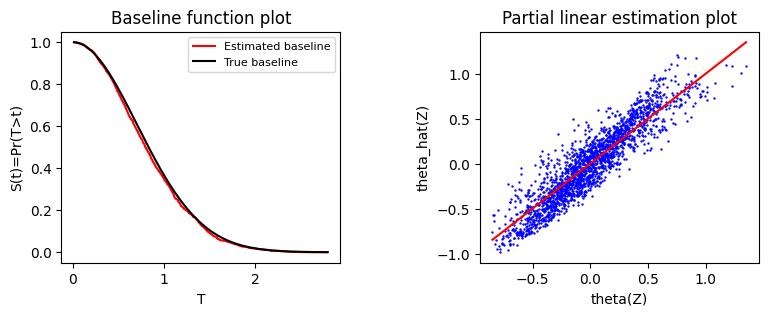

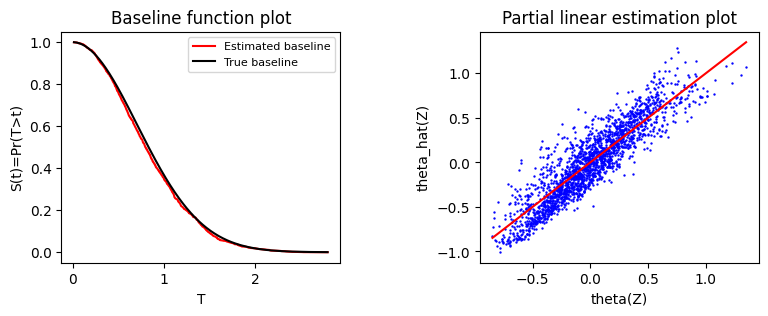

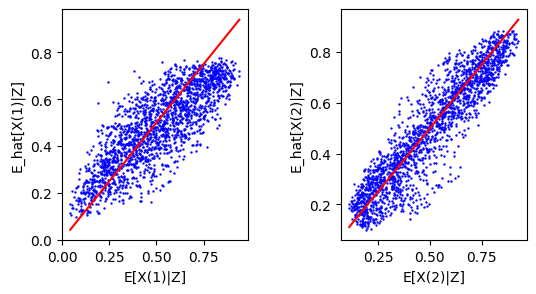

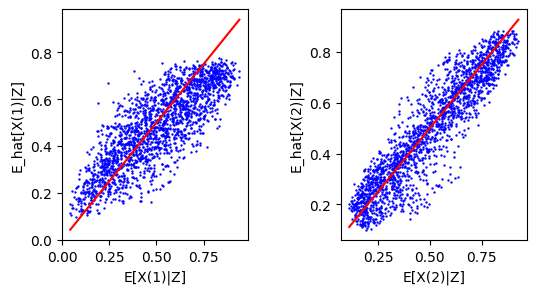

In [32]:
def Baseline_func(x): return torch.exp(-x**2)
deepSurv1.plot(theta=theta,Baseline=Baseline_func,Z_new=sim_data_test.Z)
deepSurv2.plot(theta=theta,Baseline=Baseline_func,Z_new=sim_data_test.Z)
model_XZ1.plot2(sim_data,E_XZ=E_XZ,Z_new=sim_data_test.Z)
model_XZ2.plot2(sim_data,E_XZ=E_XZ,Z_new=sim_data_test.Z)

## Testing doubly robust method for $\theta(x)=\{x_1^2x_2^2+\log(x_3+1)+\sqrt{x_4x_5+1}+e^{x_5/2}\}^2/20-6$

In [3]:
# sampling number
N=2000
# parameter part
beta = torch.tensor([-0.2,0.1])
Z_dim=5
# Non-parameter part
def theta(x):
    return torch.unsqueeze((x[:,0]**2 * x[:,1]**2 + torch.log((x[:,2]+1)**2)/2 + torch.sqrt(x[:,3]*x[:,4]+1)+torch.exp(x[:,4]/2))**2/20,1)
    # return torch.unsqueeze(torch.sqrt(x[:,3]+1)+x[:,4]/5,1)
    #return torch.unsqueeze(torch.mean(x,1),1)

def E_XZ(Z,X_dim):
    np.random.seed(204)
    A = torch.tensor(np.random.normal(0,1,size=( 3*Z.shape[1], X_dim))).float()
    eta = torch.cat((2*torch.sin(Z*2), 0.2*Z,torch.sin(Z*6)),1) @ A
    return torch.sigmoid(feature_normalize(eta))
    # return torch.sigmoid(eta)

def dist_Z(N,Z_dim=Z_dim,rho_Z=0):
    mean = torch.zeros(Z_dim)
    covariance_matrix = torch.zeros((Z_dim, Z_dim))
    
    for i in range(Z_dim):
        for j in range(Z_dim):
            covariance_matrix[i, j] = rho_Z**np.abs(i-j)
    multivariate_normal = MultivariateNormal(mean, covariance_matrix)
    Z = multivariate_normal.sample((N,))
    
    normal_dist = Normal(mean, 1)
    Z = normal_dist.cdf(Z)
    return Z

# define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
model_XZ = nn.Sequential(
    nn.Linear(Z_dim,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,len(beta)),
    nn.Sigmoid(),
)

# define the neural network framework used to train theta(Z)
model_theta = nn.Sequential(
    nn.Linear(Z_dim,25),
    nn.ReLU(),
    nn.Linear(25,25),
    nn.ReLU(),
    nn.Linear(25,1),
)

Epoch_XZ=1101
lr_XZ=27e-4
Epoch_theta=2201
lr_theta=40e-4

censor_ave=2
accuray=0.1
cut=3

### Nuisance function fitting

In [142]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')


T_interval = torch.quantile(sim_data.T,torch.arange(0,0.9,0.2).to(device))
print('train E[X|Z,T>t]')
model_XZ1 = fit_XZ_complete(sim_data,T_interval,device=device,loss_fn=nn.BCELoss(),
                           model=model_XZ, lr=lr_XZ, Epoch=Epoch_XZ,
                           Test_set=sim_data_test)

print('train theta:')
beta_est,theta_est = fit_CoxPH(sim_data,device=device,
                               model=model_theta, lr=lr_theta, Epoch=Epoch_theta,
                               Test_set=sim_data_test)
print(beta_est.cpu()-beta)

train E[X|Z,T>t]
epoch: 0 Train_loss:3.47119, epoch: 0 Test_loss:3.43672
epoch: 10 Train_loss:3.22037, epoch: 10 Test_loss:3.16514
epoch: 20 Train_loss:3.13753, epoch: 20 Test_loss:3.09656
epoch: 30 Train_loss:3.10190, epoch: 30 Test_loss:3.08089
epoch: 40 Train_loss:3.06705, epoch: 40 Test_loss:3.06175
epoch: 50 Train_loss:3.03496, epoch: 50 Test_loss:3.05689
epoch: 60 Train_loss:3.00182, epoch: 60 Test_loss:3.05631
epoch: 70 Train_loss:2.97019, epoch: 70 Test_loss:3.06234
train theta:
epoch: 0 Train_loss:4.03919, epoch: 0 Test_loss:3.84702
epoch: 10 Train_loss:4.02116, epoch: 10 Test_loss:3.83034
epoch: 20 Train_loss:4.01380, epoch: 20 Test_loss:3.82351
epoch: 30 Train_loss:4.01217, epoch: 30 Test_loss:3.82219
epoch: 40 Train_loss:4.00974, epoch: 40 Test_loss:3.82128
epoch: 50 Train_loss:4.00751, epoch: 50 Test_loss:3.82071
epoch: 60 Train_loss:4.00520, epoch: 60 Test_loss:3.81990
epoch: 70 Train_loss:4.00294, epoch: 70 Test_loss:3.81935
epoch: 80 Train_loss:4.00064, epoch: 80 Test_l

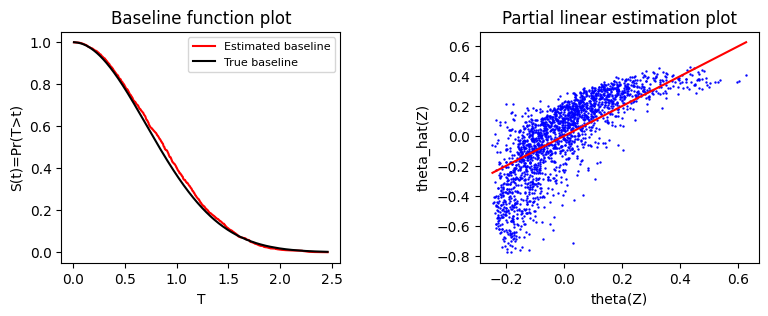

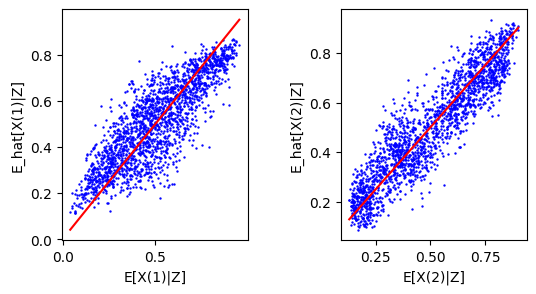

In [143]:
def Baseline_func(x): return torch.exp(-x**2)
deepSurv = DeepSurv(sim_data,beta_est,theta_est,device)
deepSurv.plot(theta=theta,Baseline=Baseline_func,Z_new=sim_data_test.Z)
model_XZ1.plot2(sim_data,E_XZ=E_XZ,Z_new=sim_data_test.Z)

### Doubly robust fitting

In [17]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='binomial')


# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

# train the double robust model
(beta_DB, var_est_DB, 
 beta_est1, deepSurv1,  model_XZ1, 
 beta_est2, deepSurv2, model_XZ2) = DML_CoxPH(sim_data, device=device,accuracy=0.2, Early_stop=True,
                                              Test_set= sim_data_test,loss_XZ=nn.BCELoss(),
                                              model_XZ=model_XZ, model_theta=model_theta,
                                              Epoch_XZ=Epoch_XZ, Epoch_theta=Epoch_theta,
                                              lr_XZ=lr_XZ, lr_theta=lr_theta,
                                              print_state=True)

net = CustomNet(h_dims=[1, 50,100,100, len(beta)], g_dims=[Z_dim,50,100,100, len(beta)])
var_est_naive = fit_variance(sim_data, net, device=device, lr=5e-3,print_state=True)

# calculate the direct parameter estimator without using double robust techniques
beta_naive=(beta_est1+beta_est2)/2
# calculate the p_value
beta=beta.to(device)


未删失样本数： tensor(1316., device='cuda:4')
train theta(Z)
epoch: 0 Train_loss:4.28537, epoch: 0 Test_loss:4.23324
epoch: 10 Train_loss:4.27361, epoch: 10 Test_loss:4.22353
epoch: 20 Train_loss:4.26506, epoch: 20 Test_loss:4.21677
epoch: 30 Train_loss:4.25716, epoch: 30 Test_loss:4.21023
epoch: 40 Train_loss:4.24941, epoch: 40 Test_loss:4.20509
epoch: 50 Train_loss:4.24155, epoch: 50 Test_loss:4.20133
epoch: 60 Train_loss:4.23368, epoch: 60 Test_loss:4.19887
epoch: 70 Train_loss:4.22607, epoch: 70 Test_loss:4.19802
epoch: 80 Train_loss:4.21895, epoch: 80 Test_loss:4.19803
train E[X|Z,T>t]
epoch: 0 Train_loss:3.45553, epoch: 0 Test_loss:3.43136
epoch: 10 Train_loss:3.22584, epoch: 10 Test_loss:3.22331
epoch: 20 Train_loss:3.07321, epoch: 20 Test_loss:3.12351
epoch: 30 Train_loss:3.05458, epoch: 30 Test_loss:3.12347
epoch: 40 Train_loss:3.03044, epoch: 40 Test_loss:3.11068
epoch: 50 Train_loss:3.00937, epoch: 50 Test_loss:3.11549
train theta(Z)
epoch: 0 Train_loss:4.24590, epoch: 0 Test_loss:

In [ ]:
print()
chi_value = torch.squeeze((beta_naive-beta) @ torch.inverse(var_est_naive) @ torch.unsqueeze(beta_naive-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_naive))
p_value_single = 1 - chi2.cdf(((beta_naive-beta)**2/torch.diag(var_est_naive)).cpu(),1)
print('PL Cox bias：',beta_naive-beta,'bias norm:',torch.norm(beta_naive-beta))
print('PL Cox standard error：',torch.sqrt(torch.diag(var_est_naive)))
print('PL Cox test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_naive)):
    print('PL Cox test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))


print()
chi_value = torch.squeeze((beta_DB-beta) @ torch.inverse(var_est_DB) @ torch.unsqueeze(beta_DB-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_DB))
p_value_single = 1 - chi2.cdf(((beta_DB-beta)**2/torch.diag(var_est_DB)).cpu(),1)
print('DBPL bias：',beta_DB-beta,'DBPL bias：',torch.norm(beta_DB-beta))
print('DBPL standard error：',torch.sqrt(torch.diag(var_est_DB)))
print('DBPL test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_DB)):
    print('DBPL test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))

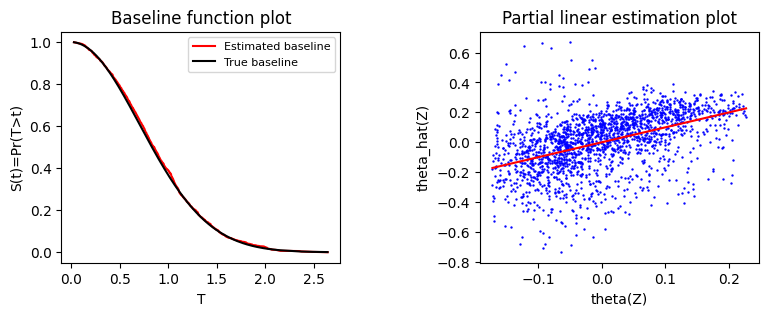

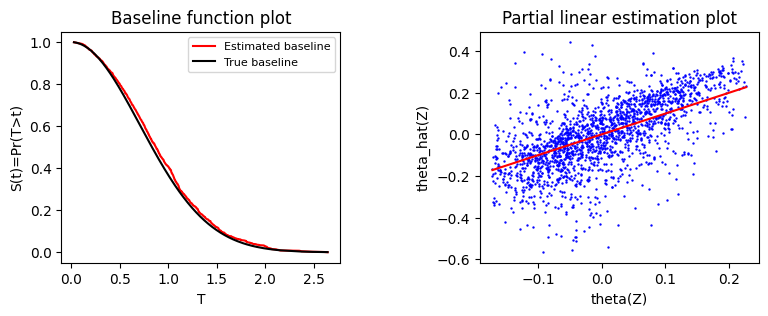

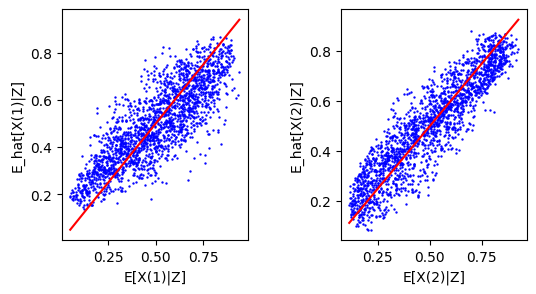

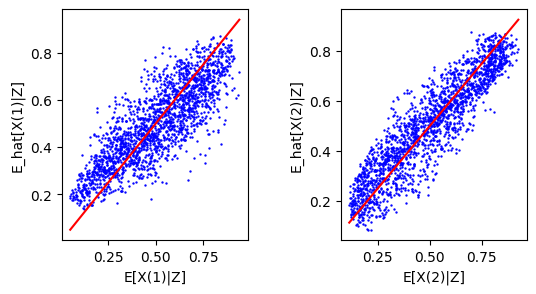

In [18]:
def Baseline_func(x): return torch.exp(-x**2)
deepSurv1.plot(theta=theta,Baseline=Baseline_func,Z_new=sim_data_test.Z)
deepSurv2.plot(theta=theta,Baseline=Baseline_func,Z_new=sim_data_test.Z)
model_XZ1.plot2(sim_data,E_XZ=E_XZ,Z_new=sim_data_test.Z)
model_XZ2.plot2(sim_data,E_XZ=E_XZ,Z_new=sim_data_test.Z)